In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
from joblib import delayed, Parallel
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from scipy.stats import bootstrap
from scipy import stats
from itertools import product 
from scipy import optimize
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import QuantileRegressor

In [3]:
# We create a string pool which will be used as substitutions during the AI calculations.
str_pool=[chr(z) for z in range(33,320) if chr(z) not in 
 ['\"','\'','\\','\x7f',
 '\x80',
 '\x81',
 '\x82',
 '\x83',
 '\x84',
 '\x85',
 '\x86',
 '\x87',
 '\x88',
 '\x89',
 '\x8a',
 '\x8b',
 '\x8c',
 '\x8d',
 '\x8e',
 '\x8f',
 '\x90',
 '\x91',
 '\x92',
 '\x93',
 '\x94',
 '\x95',
 '\x96',
 '\x97',
 '\x98',
 '\x99',
 '\x9a',
 '\x9b',
 '\x9c',
 '\x9d',
 '\x9e',
 '\x9f',
 '\xa0',
 '\xad']]

In [4]:
# function to find the minimum number of bits to represent the all the basic elements of a string (unique characters).
def min_power(sz):
    for p in range(100):
        if 2**p>=sz:
            return p
        else:
            pass
# function to decompose a number "n" base "b" with fixed output size "n_digits".        
def decompose(n,b,n_digits):
    out=[]
    n_new = n
    for k in range(n_digits):
        dgt = n_new//(b**(n_digits-1-k))
        out.append(dgt)
        n_new = n_new-dgt*(b**(n_digits-1-k))
    return out

# function to apply LZW compression to string "uncompressed". Outputs the dictionary and the coded elements.
def compress_LZW(uncompressed):
    dictionary = {}
    basis_letters = list(set(uncompressed))
    min_exp_0 = min_power(len(basis_letters))
    for p,elem in enumerate(basis_letters):
        dictionary[elem] = "".join([str(z) for z in decompose(p,2,min_exp_0)])
    dict_size = len(dictionary)

    w = ""
    result = []
    delta = 0
    min_exp = min_exp_0
    for p,c in enumerate(uncompressed):
        wc = w+c
        if wc in dictionary:
            w = wc
        else:
            if dict_size>=np.sum([2**y for y in range(min_exp_0,min_exp+1)]):
                delta = np.sum([2**y for y in range(min_exp_0,min_exp+1)])
                min_exp = min_exp+1
            else:
                pass

            result.append(dictionary[w])
            dictionary[wc] = "".join([str(z) for z in decompose(dict_size-delta,2,min_exp)])
            dict_size += 1
            w = c
    if w:
        result.append(dictionary[w])
    return dictionary,result

In [5]:
# function to filter substrings which are really present in the string "uncompressed" and have not been artificially 
# created after adding dummy characters. "ori_set" is the set of unique characters in the original unmodified string and
# "candidates" is a list containing the cadidate substrings to be filtered.
def filter_repts(canditates,uncompressed,ori_set):
    out_count = []
    for ccc in canditates:
        str_un = uncompressed
        cp=0
        pos_str = str_un.find(ccc)
        while pos_str!=-1:
            str_un_arr = np.array(list(str_un))
            str_un_arr[pos_str:pos_str+len(ccc)]=np.array(["~"]*len(ccc))
            str_un = "".join(list(str_un_arr))
            pos_str = str_un.find(ccc)
            cp+=1
        out_count.append([cp,ccc])
    return [x[1] for x in out_count if (x[0]>1)and(np.all([z in ori_set for z in x[1]]))]

# function to get substrings of string "s" starting from a location "loc".
def getsubs(loc, s):
    substr = s[loc:]
    i = -1
    while(substr):
        yield substr
        substr = s[loc:i]
        i -= 1
# function to get longest substring which repeats itself inside string "r" at least "minocc" times.
# "ori_set" is the set of unique characters in the original unmodified string.
def longestRepetitiveSubstring(r,ori_set,minocc=2):
    occ = defaultdict(int)
    # tally all occurrences of all substrings
    for i in range(len(r)):
        for sub in getsubs(i,r):
            occ[sub] += 1

    # filter out all substrings with fewer than minocc occurrences
    occ_minocc = [k for k,v in occ.items() if v >= minocc]
    
    # filter out all substrings which are really present in the original str and have not been artificially created after adding dummy characters
    occ_minocc = filter_repts(occ_minocc,r,ori_set)
    
    if occ_minocc:
        maxkey =  max(occ_minocc, key=len)
        if len(maxkey)>1:
            return maxkey
        else:
            return 'False'
    else:
        return 'False'

    
# this is the core of AT calculation: given and initial dictionary, a uncompressed string and a pool of strings to get dummy strings from, it outputs the 
# updated dictionary and the coded elements.
def inner_part_AT(dictionaryv,uncompressedo,str_pool):
    dict_size = len(dictionaryv)
    w = ""
    result = []
    delta = 0
    p=0
    while p<len(uncompressedo):
        idx_uncomp = np.max(np.where([uncompressedo[p:z] in dictionaryv for z in range(p+1,len(uncompressedo)+1)]))
        wn = uncompressedo[p:p+idx_uncomp+1]
        wc = w+wn
        p = p+idx_uncomp+1
        if (wc in dictionaryv):
            result.append(dictionaryv[wc])
            w = wc
        else:
            result.append(dictionaryv[wn])
            dictionaryv[wc] = [x for x in str_pool if x not in dictionaryv.values()][0]
            dict_size += 1
            w = wc

    return dictionaryv,result

# function to remove duplicated dummy strings which were inserted during the substituition process.
def remove_dupl_dummies(ssstt,ori_set):
    n_str=""
    for ids in range(len(ssstt)-1):
        if (ssstt[ids] == ssstt[ids+1])and(ssstt[ids] not in ori_set):
            pass
        else:
            n_str+=ssstt[ids]
    n_str+=ssstt[-1]
    return n_str

# function to find the largest substring of repeated strings after the removal of duplicates of dummy strings.
def find_largest_repeated(uncompressedi,ori_set):
    strs=[]
    for itm in ori_set:
        z=itm
        while z in remove_dupl_dummies(uncompressedi,ori_set):
            z+=itm  
        strs.append(z[:-1])
    return max(strs,key=len)

# function to calculate the dictionary and coded elements for string "uncompresseda" using assembly theory.
def compress_AT(uncompresseda):
    uncompressed = uncompresseda
    uncompressedi = uncompresseda
    ori_set = list(set(uncompresseda))
    result=[]
    result_comp=[]
    dictionary_base = {}
    dictionary = {}
    basis_letters = list(set(uncompressed))
    for p,elem in enumerate(basis_letters):
        dictionary_base[elem] = str_pool[p]
        dictionary[elem] = str_pool[p]

    while np.any(np.array(list(uncompressed))!="~"):
        tst_str = longestRepetitiveSubstring(remove_dupl_dummies(uncompressedi,ori_set),ori_set,2)
        if  tst_str!='False':
            longest_str = tst_str

            if longest_str in dictionary.keys():
                uncompressedi = uncompressedi.replace(longest_str, dictionary[longest_str])
                uncompressed = uncompressed.replace(longest_str, "~")
            else:
                dictionary,_ = inner_part_AT(dictionary,longest_str,str_pool)
                result_comp.append(longest_str)
                for strvv in sorted([x for x in dictionary.keys() if len(x)>=2],key=len)[::-1]:
                    uncompressedi = uncompressedi.replace(strvv, dictionary[strvv])
                    uncompressed = uncompressed.replace(strvv, "~")
        else:
            max_repeated = find_largest_repeated(uncompressedi,ori_set)
            if len(max_repeated)>1:
                dictionary,_ = inner_part_AT(dictionary,max_repeated,str_pool)
                result_comp.append(max_repeated)
                for strvv in sorted([x for x in dictionary.keys() if len(x)>=2],key=len)[::-1]:
                    uncompressedi = uncompressedi.replace(strvv, dictionary[strvv])
                    uncompressed = uncompressed.replace(strvv, "~")
            else:
                for strvv in sorted(dictionary.keys(),key=len)[::-1]:
                    uncompressedi = uncompressedi.replace(strvv, dictionary[strvv])
                    uncompressed = uncompressed.replace(strvv, "~")
            pass

    inv_map_dct = {v: k for k, v in dictionary.items()}
    lst_rep =[[pe,inv_map_dct[z]] for pe,z in enumerate(list(uncompressedi))]
    lst_rep.sort(key = lambda x: len(x[1]))
    for strvvv in lst_rep:
        str_created = strvvv[1]
        if str_created in dictionary_base.keys():
            result=result+[[strvvv[0],[dictionary_base[str_created]]]]
        else:
            dictionary_base, partial_codes = inner_part_AT(dictionary_base,str_created,str_pool)
            result.append([strvvv[0],partial_codes])
    result.sort(key = lambda x: x[0])
    result = [w[1] for w in result]
    return dictionary_base,result

In [6]:
# Some examples to show the code in action
str1 = "zbzbczbzbczbzbc"
str2 = "abracadabra"
str3 = "abrbr"
str4 = "bbcczzzbbzbbzzc"
str5 = "zbbzbbzzcbbcczz"

In [7]:
compress_AT(str1)

({'z': '!', 'b': '#', 'c': '$', 'zb': '%', 'zbzb': '&', 'zbzbc': '('},
 [['!', '#', '%', '$'], ['('], ['(']])

In [8]:
compress_AT(str2)

({'d': '!',
  'r': '#',
  'c': '$',
  'b': '%',
  'a': '&',
  'ab': '(',
  'abr': ')',
  'abra': '*'},
 [['&', '%', '#', '&'], ['$'], ['&'], ['!'], ['*']])

In [9]:
compress_LZW(str2)

({'d': '000',
  'r': '001',
  'c': '010',
  'b': '011',
  'a': '100',
  'ab': '101',
  'br': '110',
  'ra': '111',
  'ac': '0000',
  'ca': '0001',
  'ad': '0010',
  'da': '0011',
  'abr': '0100'},
 ['100', '011', '001', '100', '010', '100', '000', '101', '111'])

In [10]:
compress_AT(str3)

({'a': '!', 'r': '#', 'b': '$', 'br': '%'}, [['!'], ['$', '#'], ['%']])

In [11]:
compress_AT(str4)

({'z': '!', 'b': '#', 'c': '$', 'bb': '%', 'cc': '&', 'zz': '(', 'zbb': ')'},
 [['#', '#'], ['$', '$'], ['!', '!'], ['!', '%'], [')'], ['('], ['$']])

In [12]:
compress_AT(str5)

({'z': '!', 'b': '#', 'c': '$', 'zz': '%', 'bb': '&', 'cc': '(', 'zbb': ')'},
 [['!', '&'], [')'], ['!', '!'], ['$'], ['#', '#'], ['$', '$'], ['%']])

In [13]:
# function for flattening lists
def flatten(xss):
    return [x for xs in xss for x in xs]

#Now, let us define a function which computes both LZW and AI and outputs:
# a) length of LZW list of codes
# b) length of unique values in LZW list of codes
# c) AI
# d) length of unique values in AT list of codes
# e) length of unique characters in input string
# f) length of LZW dictionary
# g) length of AT dictionary
# h) length of input string
def LZW_AT(strv):
    a1,a2 = compress_LZW(strv)
    a3,a4 = compress_AT(strv)
    return [len(a2),len(set(a2)),len(flatten(a4))-1,len(set(flatten(a4))),len(set(strv)),len(a1),len(a3),len(strv)]

In [14]:
# Let us reproduce the plot in Figure 4 of the paper "Assembly Theory and its Relationship with Computational Complexity" by Kempes et al. (2024):

np.random.seed(42)

compare_lst=[]
base_str_v = "zbzbczbzbczbzbc"

for _ in range(10000):
    str_var = list(base_str_v)
    np.random.shuffle(str_var)
    new_str = ''.join(str_var)
    compare_lst.append(LZW_AT(new_str))
    
df_tot = pd.DataFrame(compare_lst)
df_tot.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]

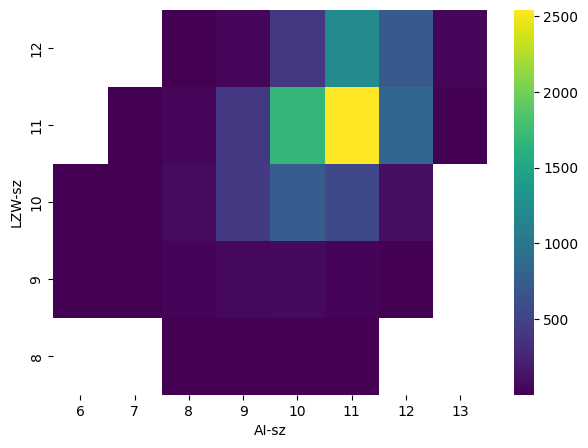

In [15]:
new_df = df_tot.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(7, 5))
glue = new_df.pivot(index="LZW-sz", columns="AI-sz", values="Count")
sns.heatmap(glue,cmap = 'viridis')
ax.invert_yaxis()

In [21]:
# Now, let us consider the alphanumerical values in "base_str_v". We will:
# for "k" from 2 to "l_max":
#      randomly pick "nreps" strings of size "k" (with repetition) from "base_str_v" and calculate LZW and AI.
# We used parallelization to make things go faster.

base_str_v = "abcdefghijklmnopqrstuvwxyz"
npar=24
nreps = 10000
l_max = 100
rseed = 42
inpts_all = [[base_str_v,sz,nreps,rseed+sz] for sz in range(2,l_max+1)]

def inner_calc(inptt):
    lst_str,idxsvi = inptt
    out_lst = []
    for iii in idxsvi:
        new_str = ''.join(list(lst_str[iii]))
        out_lst.append(LZW_AT(new_str))
    return out_lst

compare_lst=[]
for inpts in  tqdm(inpts_all):
    base_str_v,sz,nreps,rseed = inpts
    np.random.seed(rseed)
    # idxsv = np.random.randint(0,len(base_str_v), size=(nreps,sz))
    idxsv = np.random.randint(0,len(base_str_v), size=(nreps//500,500,sz))
    lst_str = np.array(list(base_str_v))
    # inpt_compl = [''.join(list(lst_str[iii])) for iii in idxsv]
    inpt_compl = [[lst_str,iid] for iid in idxsv]
    transf_lst = flatten(Parallel(n_jobs=npar)(delayed(inner_calc)(x) for x in inpt_compl))
    compare_lst=compare_lst+transf_lst

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [36:09<00:00, 21.92s/it]


In [22]:
df_tot = pd.DataFrame(compare_lst)
df_tot.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]

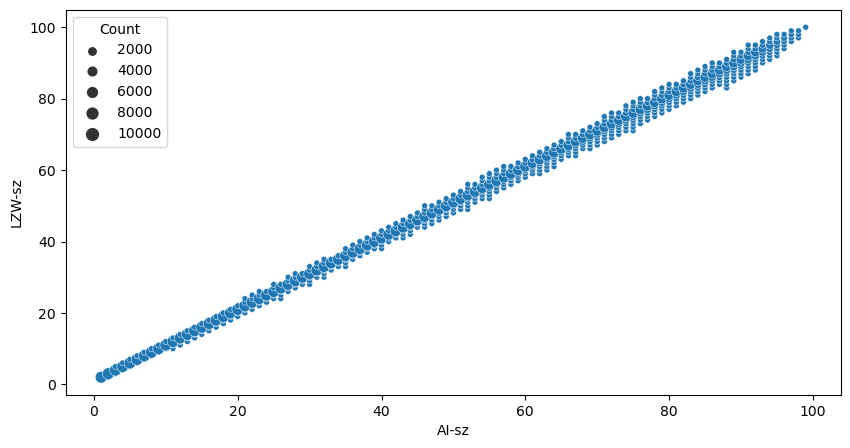

In [23]:
new_df = df_tot.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.scatterplot(data=new_df, x='AI-sz', y='LZW-sz', size='Count', ax=ax)
xticks = list(set(new_df['AI-sz']))
yticks = list(set(new_df['LZW-sz']))

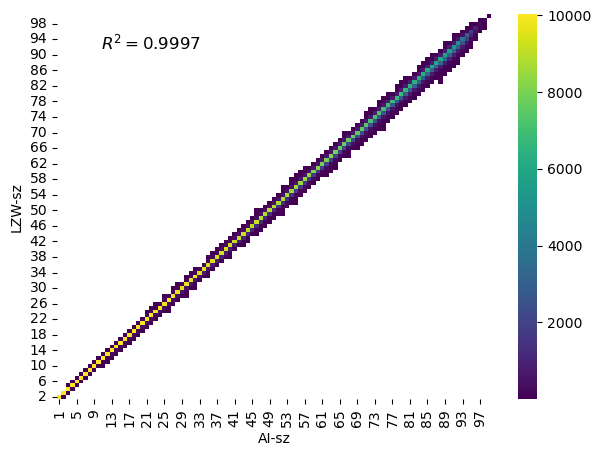

In [62]:
Xval = df_tot[["AI-sz"]].to_numpy()
yval = df_tot[["LZW-sz"]].to_numpy()
reg = LinearRegression().fit(Xval, yval)

new_df = df_tot.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(7, 5))
glue = new_df.pivot(index="LZW-sz", columns="AI-sz", values="Count")
sns.heatmap(glue,cmap = 'viridis')
plt.text(10, 90, '$R^2 = $'+str(np.round(reg.score(Xval, yval),4)), fontsize = 12)
ax.invert_yaxis()

In [187]:
# For the ZBC string:
base_str_v = "zbzbczbzbczbzbc"
npar=24
nreps = 10000
l_max = 100
rseed = 42
inpts_all = [[base_str_v,sz,nreps,rseed+sz] for sz in range(2,l_max+1)]

def inner_calc(inptt):
    lst_str,idxsvi = inptt
    out_lst = []
    for iii in idxsvi:
        new_str = ''.join(list(lst_str[iii]))
        out_lst.append(LZW_AT(new_str))
    return out_lst

compare_lst_2=[]
for inpts in  tqdm(inpts_all):
    base_str_v,sz,nreps,rseed = inpts
    np.random.seed(rseed)
    idxsv = np.random.randint(0,len(base_str_v), size=(nreps//500,500,sz))
    lst_str = np.array(list(base_str_v))
    inpt_compl = [[lst_str,iid] for iid in idxsv]
    transf_lst = flatten(Parallel(n_jobs=npar)(delayed(inner_calc)(x) for x in inpt_compl))
    compare_lst_2=compare_lst_2+transf_lst

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [16:34<00:00, 10.04s/it]


In [188]:
df_tot_n = pd.DataFrame(compare_lst_2)
df_tot_n.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]

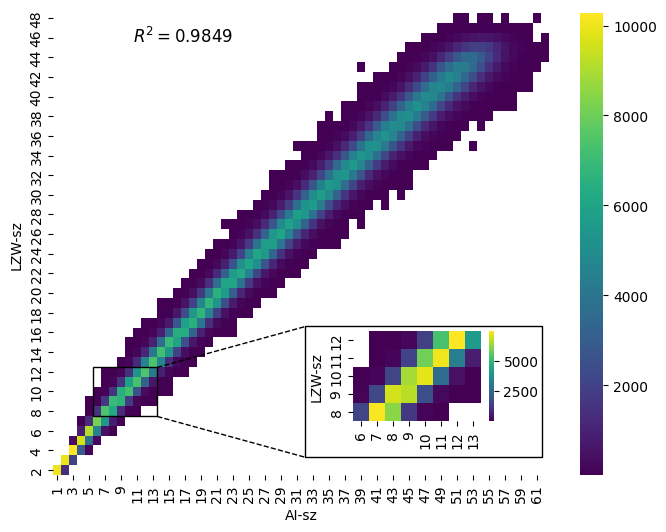

In [191]:
Xval = df_tot_n[["AI-sz"]].to_numpy()
yval = df_tot_n[["LZW-sz"]].to_numpy()
reg = LinearRegression().fit(Xval, yval)

new_df_n = df_tot_n.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
glue = new_df_n.pivot(index="LZW-sz", columns="AI-sz", values="Count")
sns.heatmap(glue,cmap = 'viridis',ax=ax)
plt.text(10, 44, '$R^2 = $'+str(np.round(reg.score(Xval, yval),4)), fontsize = 12)
ax.invert_yaxis()

ax.plot([13,31.5],[5.95,1.8], color = "k", lw=1, ls="--")
ax.plot([13,31.5],[10.95,15.1], color = "k", lw=1, ls="--")

someX, someY = 5.5, 6.5
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .5, someY - .5), 8, 5,facecolor="None",edgecolor="black"))

ax2 = fig.add_axes([0.5, 0.2, 0.2, 0.15])
sns.heatmap(glue.loc[8:12,6:13],cmap = 'viridis',ax=ax2)
ax2.invert_yaxis()
ax2.set_xlabel("");

autoAxis = ax2.axis()
rec = Rectangle((autoAxis[0]-3,autoAxis[2]-2),(autoAxis[1]-autoAxis[0])+6.8,(autoAxis[3]-autoAxis[2])+2.3,fill=False,lw=1)
rec = ax2.add_patch(rec)
rec.set_clip_on(False)

In [192]:
# This dataset is for the auxiliary plots.

base_str_v = "zbzbczbzbczbzbc"
npar=24
nreps = 10000
rseed = 42
inpts_all = [[base_str_v,sz,nreps,rseed+sz] for sz in range(12,19)]

def inner_calc(inptt):
    lst_str,idxsvi = inptt
    out_lst = []
    for iii in idxsvi:
        new_str = ''.join(list(lst_str[iii]))
        out_lst.append(LZW_AT(new_str))
    return out_lst

compare_lst_3nn=[]
for inpts in  tqdm(inpts_all):
    base_str_v,sz,nreps,rseed = inpts
    np.random.seed(rseed)
    # idxsv = np.random.randint(0,len(base_str_v), size=(nreps,sz))
    idxsv = np.random.randint(0,len(base_str_v), size=(nreps//500,500,sz))
    lst_str = np.array(list(base_str_v))
    # inpt_compl = [''.join(list(lst_str[iii])) for iii in idxsv]
    inpt_compl = [[lst_str,iid] for iid in idxsv]
    transf_lst = flatten(Parallel(n_jobs=npar)(delayed(inner_calc)(x) for x in inpt_compl))
    compare_lst_3nn.append(transf_lst)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.10s/it]


In [480]:
plt.rcParams.update({'font.size': 16})

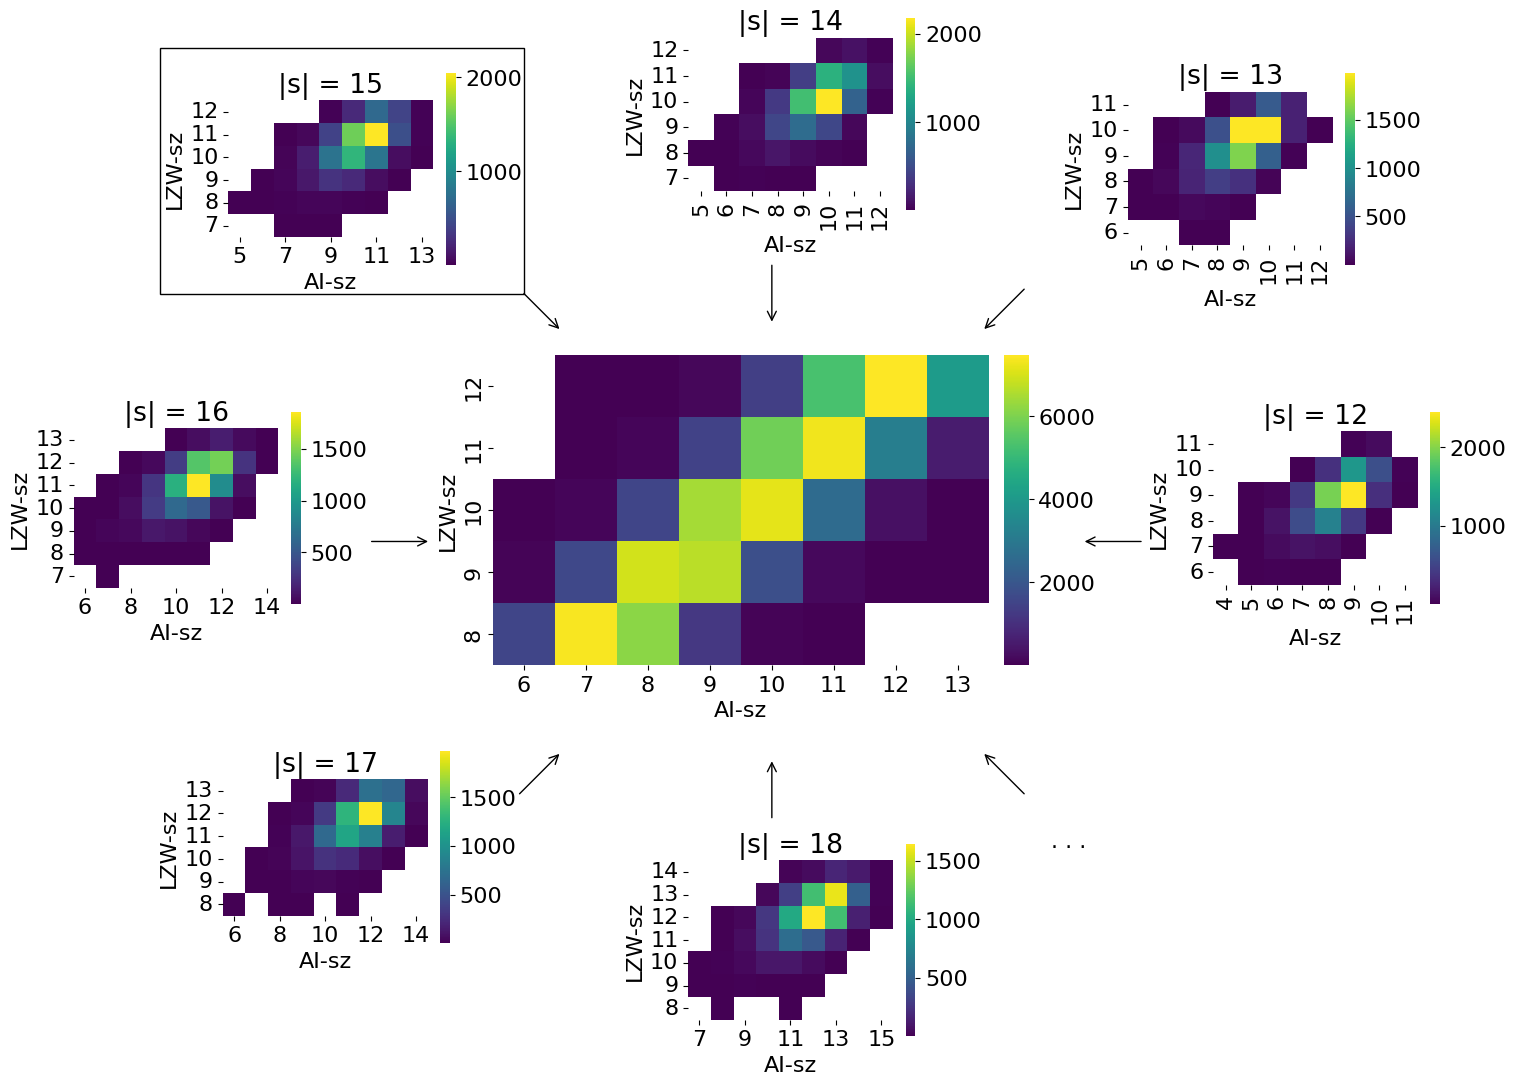

In [497]:
fig = plt.figure()
axinp = fig.add_subplot(111)

labels = ['Section '+str(x) for x in range(8)]
sizes = [20]*8

wedges, texts = axinp.pie(sizes, wedgeprops=dict(width=0.5), startangle=-22.5, radius=7, center=(4.5,2))
for i in range(len(wedges)):
    wedges[i].set_alpha(0.0)

kw = dict(arrowprops=dict(arrowstyle="->"), va="center")
for ppd, p, label in zip(np.arange(0,len(wedges)),wedges, labels):
    ang = np.deg2rad((p.theta1 + p.theta2)/2)
    y = np.sin(ang)
    x = np.cos(ang)
    horizontalalignment = "center" if abs(x) < abs(y) else "right" if x < 0 else "left"
    if (ppd==2)or(ppd==6):
        axinp.annotate("", xy=(3.5*x+4.5, 3.5*y+2), xytext=(4.5*x+4.5, 4.5*y+2),
                horizontalalignment=horizontalalignment, **kw,annotation_clip=False)
    elif (ppd==3):
        axinp.annotate("", xy=(4.8*x+4.5, 4.8*y+2), xytext=(5.7*x+4.5, 5.7*y+2),
                horizontalalignment=horizontalalignment, **kw,annotation_clip=False)
    elif (ppd==4):
        axinp.annotate("", xy=(5.5*x+4.5, 5.5*y+2), xytext=(6.5*x+4.5, 6.5*y+2),
                horizontalalignment=horizontalalignment, **kw,annotation_clip=False)
    elif (ppd==0):
        axinp.annotate("", xy=(5*x+4.5, 5*y+2), xytext=(6*x+4.5, 6*y+2),
                horizontalalignment=horizontalalignment, **kw,annotation_clip=False)
    else:
        axinp.annotate("", xy=(4.8*x+4.5, 4.8*y+2), xytext=(5.8*x+4.5, 5.8*y+2),
                horizontalalignment=horizontalalignment, **kw,annotation_clip=False)

for pdd, p, label in zip(np.arange(0,len(wedges)),wedges, labels):
    ang = np.deg2rad((p.theta1 + p.theta2)/2)
    y = np.sin(ang)
    x = np.cos(ang)
    if (pdd==2):
        ax2 = fig.add_axes([x+0.43, y+0.12, 0.4, 0.4])
    elif (pdd==6):
        ax2 = fig.add_axes([x+0.43, y+0.4, 0.4, 0.4])
    elif (pdd==0):
        ax2 = fig.add_axes([x+0.25, y+0.3, 0.4, 0.4])
    elif (pdd==4):
        ax2 = fig.add_axes([x+0.47, y+0.3, 0.4, 0.4])
    elif (pdd==3):
        ax2 = fig.add_axes([x+0.419, y+0.3, 0.4, 0.4])
    else:
        ax2 = fig.add_axes([x+0.41, y+0.3, 0.4, 0.4])
    
    if pdd==7:
        ax2.set_axis_off()
        ax2.text(-0.3, 0.5, '. . .');
    else:
        df_tot_n3 = pd.DataFrame(compare_lst_3nn[pdd])
        df_tot_n3.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]
        new_df_n3 = df_tot_n3.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')
        gluei = new_df_n3.pivot(index="LZW-sz", columns="AI-sz", values="Count")
        # sns.heatmap(gluei,cmap = 'viridis',ax = axii, clip_on=False, square=True)     
        sns.heatmap(gluei,cmap = 'viridis',ax=ax2, clip_on=False, square=True)
        ax2.invert_yaxis()
        ax2.set_title('|s| = '+str(int(pdd+12)))
    if pdd ==3:
        autoAxis = ax2.axis()
        rec = Rectangle((autoAxis[0]-3,autoAxis[2]-2.5),(autoAxis[1]-autoAxis[0])+7,(autoAxis[3]-autoAxis[2])+4.8,fill=False,lw=1)
        rec = ax2.add_patch(rec)
        rec.set_clip_on(False)
        
cax = inset_axes(axinp,
                 width="5%",  
                 height="100%", 
                 loc='lower left',
                 bbox_to_anchor=(1.03, 0, 1,1),
                 bbox_transform=axinp.transAxes,
                 borderpad=0,
                 )
sns.heatmap(glue.loc[8:12,6:13],cmap = 'viridis',ax=axinp, clip_on=False, square=True, cbar_ax=cax, cbar_kws={'orientation': 'vertical'} )
axinp.invert_yaxis()

In [296]:
# This dataset is to plot the ratios
df_tot_n["LZW/AI"] = df_tot_n["LZW-sz"]/df_tot_n["AI-sz"]
df_tot_n["LogLZW / LogAI"] = np.log(df_tot_n["LZW-sz"])/np.log(df_tot_n["AI-sz"])

In [498]:
# Same CBZ example but now with strings of length up to 200.

base_str_v = "zbzbczbzbczbzbc"
npar=24
nreps = 10000
l_max = 200
rseed = 42
inpts_all = [[base_str_v,sz,nreps,rseed+sz] for sz in range(2,l_max+1)]

def inner_calc(inptt):
    lst_str,idxsvi = inptt
    out_lst = []
    for iii in idxsvi:
        new_str = ''.join(list(lst_str[iii]))
        out_lst.append(LZW_AT(new_str))
    return out_lst

compare_lst_200=[]
for inpts in  tqdm(inpts_all):
    base_str_v,sz,nreps,rseed = inpts
    np.random.seed(rseed)
    # idxsv = np.random.randint(0,len(base_str_v), size=(nreps,sz))
    idxsv = np.random.randint(0,len(base_str_v), size=(nreps//500,500,sz))
    lst_str = np.array(list(base_str_v))
    # inpt_compl = [''.join(list(lst_str[iii])) for iii in idxsv]
    inpt_compl = [[lst_str,iid] for iid in idxsv]
    transf_lst = flatten(Parallel(n_jobs=npar)(delayed(inner_calc)(x) for x in inpt_compl))
    compare_lst_200=compare_lst_200+transf_lst

100%|██████████████████████████████████████████████████████████████████████████████| 199/199 [2:18:26<00:00, 41.74s/it]


In [499]:
df_tot_n200 = pd.DataFrame(compare_lst_200)
df_tot_n200.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]

In [500]:
Xval = df_tot_n200[["AI-sz"]].to_numpy()
yval = df_tot_n200[["LZW-sz"]].to_numpy()
reg = LinearRegression().fit(Xval, yval)

new_df_n200 = df_tot_n200.groupby(['AI-sz', 'LZW-sz']).size().reset_index(name='Count')

In [528]:
# Plots with dataset with strings of length up to 200
df_tot_n200["LZW/AI"] = df_tot_n200["LZW-sz"]/df_tot_n200["AI-sz"]
df_tot_n200["LogLZW / LogAI"] = np.log(df_tot_n200["LZW-sz"])/np.log(df_tot_n200["AI-sz"])

In [532]:
mus_sigmas_diff=[]
szall = np.arange(2,201)
for szii in szall:
    v1,v2 = df_tot_n200[df_tot_n200["delta_l"]==szii][["LogLZW","LogAI"]].to_numpy().T
    x = (v1/v2)
    mus_sigmas_diff.append([szii,np.mean(x),np.std(x)])
    
mus_sigmas_diff = np.array(mus_sigmas_diff)

C:\Users\luano\AppData\Local\Temp\ipykernel_14776\3202233479.py:5: RuntimeWarning: divide by zero encountered in divide
  x = (v1/v2)
C:\Users\luano\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


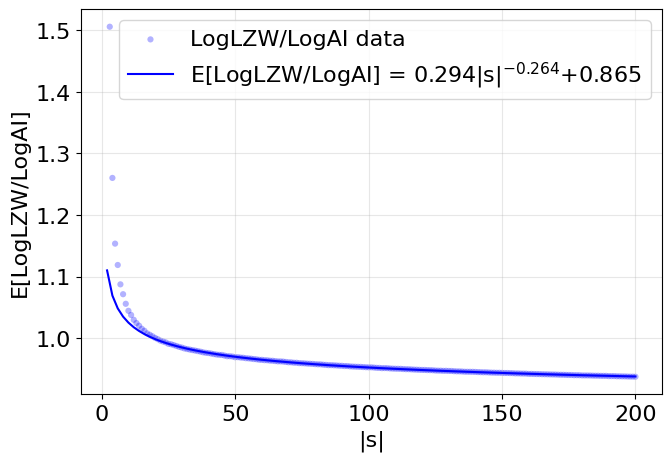

In [544]:
def gunc(x, a, c,b):                              
    return a * (x)**(c) +b

initv = [2,-0.38,0.3]
fig, ax = plt.subplots(figsize = (7.5,5))
for pp,vs in enumerate([mus_sigmas_diff]):
    ax.scatter(vs[:,0], vs[:,1], c=["blue","green"][pp], s=20, label=["LogLZW/LogAI data"][pp],
               alpha=0.3, edgecolors='none')
    mask = (vs[:,0]>20)
    fit, covariance = optimize.curve_fit(           
            gunc,                                     
            vs[:,0][mask],   
            vs[:,1][mask],    
            initv)   
    x_fit = np.linspace(vs[:,0].min(), vs[:,0].max(), 100)
    y_fit = gunc(x_fit, *fit)
    plt.plot(x_fit, y_fit, c=["blue","green"][pp], label="E[LogLZW/LogAI] = "+str(round(fit[0],3))+"|s|$^{"+str(round(fit[1],3))+"}$+"+str(round(fit[2],3)))


ax.legend()
ax.grid(True,alpha = 0.3)
ax.set_xlabel("|s|")
ax.set_ylabel("E[LogLZW/LogAI]")

plt.show()

C:\Users\luano\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


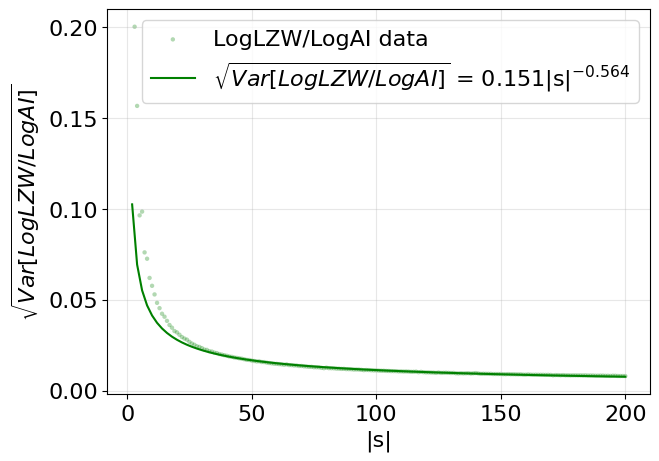

In [548]:
def gunc(x, a, c,b):                              
    return a * (x)**(c) 

initv = [2,-0.38,0]

fig, ax = plt.subplots(figsize=(7,5))
for pp,vs in enumerate([mus_sigmas_diff]):
    ax.scatter(vs[:,0], vs[:,2], c=["green"][pp], s=10, label=["LogLZW/LogAI data"][pp],
               alpha=0.3, edgecolors='none')
    mask = (vs[:,0]>30)
    fit, covariance = optimize.curve_fit(           
            gunc,                                     
            vs[:,0][mask],   
            vs[:,2][mask],    
            initv)   
    x_fit = np.linspace(vs[:,0].min(), vs[:,0].max(), 100)
    y_fit = gunc(x_fit, *fit)
    plt.plot(x_fit, y_fit, c=["green"][pp], label="$\sqrt{Var[LogLZW/LogAI]}$ = "+str(round(fit[0],3))+"|s|$^{"+str(round(fit[1],3))+"}$")


ax.legend()
ax.grid(True,alpha = 0.3)
ax.set_xlabel("|s|")
ax.set_ylabel("$\sqrt{Var[LogLZW/LogAI]}$")

plt.show()

In [75]:
# We can import data from Fig3 and Fig4 from Marshall et al. (2021) paper:
dict_ac2={}
strv=""
indv="0"
p=0
lst_all=[]
with open("DataMolecules.csv",'rt') as f:
    for line in f:
        try:
            upp,dpp = line.split("\"\"InChI=1S/")
            dpp1,dpp2 = dpp.split("\"\",")
            lst_all.append([upp.split(",")[1],dpp1,dpp2.split(",")[0]])
        except:
            pass
        
dict_ac2={}
strv=""
indv="0"
p=0
lst_all_n=[]
with open("MS_data_Standard_Curve.csv",'rt') as f:
    for line in f:
        try:
            upp,dpp = line.split("\"\"InChI=1S/")
            dpp1,dpp2 = dpp.split("\"\",")
            lst_all_n.append([upp.split(",")[1],dpp1,dpp2.split(",")[0],float(dpp2.split(",")[1]),dpp2.split(",")[2].split("\";")[0]])
        except:
            pass

In [76]:
df_data = pd.DataFrame(lst_all)
df_data.columns = ["Name","InChI","MA"]

df_data_2 = pd.DataFrame(lst_all_n)
df_data_2.columns = ["Name","InChI","MA","MS2","Type"]

In [77]:
lzwai_lst3 = [LZW_AT("/c"+x[1].split("/c")[1]) for x in lst_all_n]

In [78]:
df_lzwai3=pd.DataFrame(lzwai_lst3)
df_lzwai3.columns = ["LZW-sz","LZW-sz-unique","AI-sz","AI-sz-unique","n_symbs","dict_LZW","dict_AT","delta_l"]

In [79]:
filttp = np.array([x.strip("\"\n") for x in df_data_2["Type"].to_numpy()])=='Small Molecules'

In [80]:
df_plt = pd.DataFrame([df_data_2["MA"].to_numpy().astype('int'),df_lzwai3["LZW-sz"].to_numpy(),df_lzwai3["AI-sz"].to_numpy(),df_data_2["MS2"].to_numpy(),np.array([x.strip("\"\n") for x in df_data_2["Type"].to_numpy()]),np.array([len(x) for x in df_data_2["InChI"].to_numpy()])]).T
df_plt.columns = ["MA","LZW","AI","MS2","Type","Length of InChI"]

In [81]:
df_lst_conc = []
for colv in ["MA","LZW","AI","MS2","Length of InChI"]:
    df_intrm = df_plt[[colv,"Type"]].copy()
    df_intrm.loc[:,"Algorithm"] = [colv]*len(df_intrm)
    df_intrm.columns = ["Value","Type","Algorithm"]
    df_lst_conc.append(df_intrm)

In [82]:
df_conct_final = pd.concat(df_lst_conc)

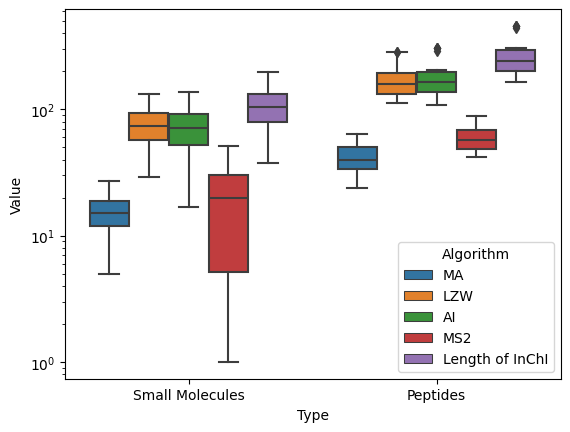

In [83]:
ax = sns.boxplot(x="Type", y="Value", hue= "Algorithm", data=df_conct_final) 
plt.yscale("log")  
plt.show()

In [26]:
# In order to compare how well each metric separated the data, it is possible to perform a pair-wise equality of distribution test. 
# We chose Cucconi test (which tests if the two groups have the same mean and scale).
# The cucconi test code below was slightly adapted from the implementation by Grzegorz Mika found in https://github.com/GrzegorzMika/NonParStat/tree/master

def _cucconi_test_statistic(a, b, ties='average'):
    n1 = len(a)
    n2 = len(b)
    n = n1 + n2
    alldata = np.concatenate((a, b))
    ranked = stats.rankdata(alldata, method=ties)
    a_ranks = ranked[:n1]

    rho = 2 * (n ** 2 - 4) / ((2 * n + 1) * (8 * n + 11)) - 1
    U = (6 * np.sum(np.square(a_ranks)) - n1 * (n + 1) * (2 * n + 1)) / np.sqrt(
        n1 * n2 * (n + 1) * (2 * n + 1) * (8 * n + 11) / 5)
    V = (6 * np.sum(np.square(n + 1 - a_ranks)) - n1 * (n + 1) * (2 * n + 1)) / np.sqrt(
        n1 * n2 * (n + 1) * (2 * n + 1) * (8 * n + 11) / 5)
    C = (U ** 2 + V ** 2 - 2 * rho * U * V) / 2 * (1 - rho ** 2)

    return C


def _cucconi_dist_permutation(a, b, replications=1000, ties='average'):
    n1 = len(a)
    h0_data = np.concatenate([a, b])

    def permuted_test(replication_index):
        permuted_data = np.random.permutation(h0_data)
        new_a = permuted_data[:n1]
        new_b = permuted_data[n1:]
        return _cucconi_test_statistic(a=new_a, b=new_b, ties=ties)

    return sorted([permuted_test(i) for i in range(replications)])


def _cucconi_dist_bootstrap(a, b, replications=1000, ties='average'):
    n1 = len(a)
    n2 = len(b)
    h0_data = np.concatenate([a, b])

    def bootstrap_test(replication_index):
        new_a = np.random.choice(h0_data, size=n1, replace=True)
        new_b = np.random.choice(h0_data, size=n2, replace=True)
        return _cucconi_test_statistic(new_a, new_b, ties=ties)

    return np.array([bootstrap_test(i) for i in range(replications)])


def cucconi_test(a, b, method='bootstrap', replications=1000, ties='average'):
    """
    Method to perform a Cucconi scale-location test.
    Args:
        a (np.ndarray): vector of observations
        b (np.ndarray): vector of observations
        method (str): method for determining p-value,
            possible values are 'bootstrap' and 'permutation'
        replications (int): number of bootstrap replications
        ties (str): string specifying a method to deal with ties in data,
            possible values as for scipy.stats.rankdata
        n_jobs (int): the maximum number of concurrently running jobs. If -1 all CPUs are used. If 1 is given,
            no parallel computing code is used at all. For n_jobs below -1, (n_cpus + 1 + n_jobs) are used.
            None is a marker for ‘unset’ that will be interpreted as n_jobs=1 (sequential execution)
        verbose (int): the verbosity level: if non zero, progress messages are printed.
            Above 50, the output is sent to stdout.
    Returns:
        tuple: namedtuple with test statistic value and the p-value
    Raises:
        ValueError: if 'method' parameter is not specified to 'bootstrap' or 'permutation'
    Examples:
        >>> np.random.seed(987654321) # set random seed to get the same result
        >>> sample_a = sample_b = np.random.normal(loc=0, scale=1, size=100)
        >>> cucconi_test(sample_a, sample_b, replications=10000)
        CucconiResult(statistic=3.7763314663244195e-08, pvalue=1.0)
        >>> np.random.seed(987654321)
        >>> sample_a = np.random.normal(loc=0, scale=1, size=100)
        >>> sample_b = np.random.normal(loc=10, scale=10, size=100)
        >>> cucconi_test(sample_a, sample_b, method='permutation')
        CucconiResult(statistic=2.62372293956099, pvalue=0.000999000999000999)
    """
    a, b = map(np.asarray, (a, b))

    test_statistics = _cucconi_test_statistic(a=a, b=b, ties=ties)

    if method == 'permutation':
        h0_distribution = _cucconi_dist_permutation(a=a, b=b, replications=replications, ties=ties)
    elif method == 'bootstrap':
        h0_distribution = _cucconi_dist_bootstrap(a=a, b=b, replications=replications, ties=ties)
    else:
        raise ValueError(
            "Unknown method for constructing the distribution, "
            "possible values are ['bootstrap', 'permutation'], but {} was provided".format(method))

    p_value = np.sum(h0_distribution >= test_statistics) / (replications)

    return [test_statistics, p_value]

In [53]:
result_testW=[]
# cross_lst = list(product(list(set(df_conct_final["Algorithm"].to_numpy())),list(set(df_conct_final["Type"].to_numpy()))))

cross_lst = [
 ('LZW', 'Peptides'),
 ('LZW', 'Small Molecules'),
 ('AI', 'Peptides'),
 ('AI', 'Small Molecules'),
 ('MS2', 'Peptides'),
 ('MS2', 'Small Molecules'),
 ('Length of InChI', 'Peptides'),
 ('Length of InChI', 'Small Molecules'),
 ('MA', 'Peptides'),
 ('MA', 'Small Molecules'),
 ]

for pp,(algov0,typmo) in enumerate(cross_lst):
    result_testWi=[]
    if pp < len(cross_lst)-1:
        for algov1,typmi in cross_lst[pp+1:]:
            sa = df_conct_final[(df_conct_final["Algorithm"]==algov0)*(df_conct_final["Type"]==typmo)]["Value"].to_numpy().astype('float')
            sb = df_conct_final[(df_conct_final["Algorithm"]==algov1)*(df_conct_final["Type"]==typmi)]["Value"].to_numpy().astype('float')
            res = cucconi_test(sa,sb)
            result_testWi.append(res)
        result_testW.append(result_testWi)

In [54]:
arr_pvals = np.zeros((len(cross_lst),len(cross_lst)))
np.fill_diagonal(arr_pvals,1)
for pp,row in enumerate(result_testW):
    for pp2 in range(len(row)):
        arr_pvals[pp,pp2+1+pp] = row[pp2][1]
arr_pvals = arr_pvals + arr_pvals.T - np.diag(np.diag(arr_pvals))

In [56]:
def Plot_HeatMap_Weights(methds,filtens,path_plot):
    filtenslab = methds
    szf = len(filtenslab)
    ax = sns.heatmap(filtens, linewidth=0.5,cmap="Blues", vmin=0, vmax=1 )
    plt.xticks([x +0.5 for x in range(szf)],filtenslab)
    plt.yticks([x + 0.5 for x in range(szf)],filtenslab)
    for px in range(szf):
        for py in range(szf):
            if np.round(filtens[py][px],2)<=0.05:
                pass
            else:
                plt.text(px+0.05, py+0.8, str(round(filtens[py][px],2)),color = 'w' ,rotation=0)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    plt.savefig(path_plot,bbox_inches='tight')
    plt.show()

In [59]:
plt.rcParams.update({'font.size': 12.5})

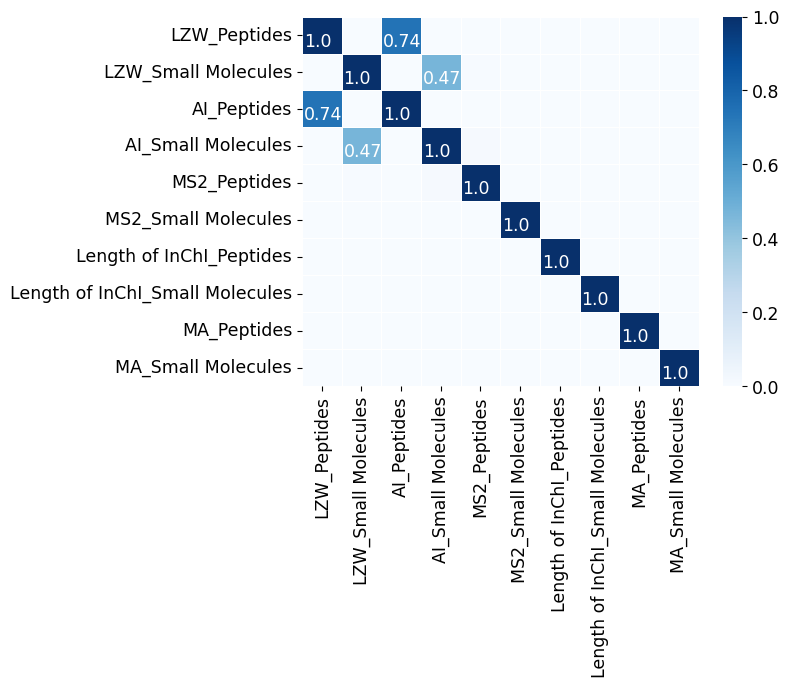

In [60]:
methds = [x[0]+"_"+x[1] for x in cross_lst]
Plot_HeatMap_Weights(methds,arr_pvals,"path.pdf")
plt.rcdefaults()

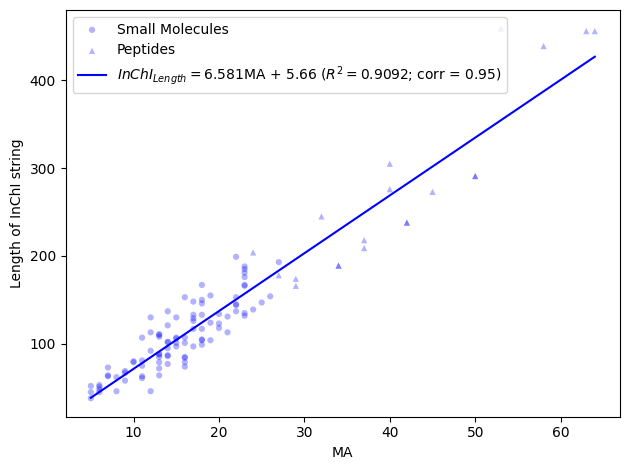

In [61]:
szm = 20
fig, ax = plt.subplots()
yv_MA = df_data_2["MA"].to_numpy().astype('int')
xv_AI = np.array([len(x) for x in df_data_2["InChI"].to_numpy()])

ax.scatter(yv_MA[filttp],xv_AI[filttp] , c="blue", s=szm, marker = "o", label="Small Molecules",
           alpha=0.3, edgecolors='none')

ax.scatter(yv_MA[~filttp],xv_AI[~filttp] , c="blue", s=szm, marker = "^", label="Peptides",
           alpha=0.3, edgecolors='none')

reg1i = LinearRegression().fit(yv_MA.reshape(-1, 1),xv_AI.reshape(-1, 1))

x_fit1 = np.linspace(yv_MA.min(), yv_MA.max(), 100)
y_fit1 = reg1i.predict(x_fit1.reshape(-1, 1))
ax.plot(x_fit1, y_fit1, c="blue", label= "$InChI_{Length}= $"+str(round(reg1i.coef_[0][0],3))+"MA + "+str(round(reg1i.intercept_[0],2))+' ($R^2 = $'+str(np.round(reg1i.score(yv_MA.reshape(-1, 1),xv_AI.reshape(-1, 1)),4))+'; corr = '+str(round(np.corrcoef(np.array([yv_MA,xv_AI]))[0][1],2))+")")

ax.set_ylabel("Length of InChI string")
ax.set_xlabel("MA")

ax.legend()
fig.tight_layout()
plt.show()

In [71]:
# We can get data from Marshall et al. (2021) again to see how each metric can be used to estimate/be estimated from MS2 data:
strv=""
indv="0"
p=0
lst_all_M=[]
with open("Murchison_Extract.csv",'rt') as f:
    for line in f:
        try:
            lst_all_M.append([z.strip() for z in line.split(",")])
        except:
            pass
        
dict_acN={}
strv=""
indv="0"
p=0
lst_all_N=[]
with open("EnviromentalSamplesUpdated_Oct2020_outsidedata_seawater.csv",'rt') as f:
    for line in f:
        try:
            lst_all_N.append([z.strip() for z in line.split(",")])
        except:
            pass

In [72]:
df_N = pd.DataFrame(lst_all_N[1:],columns = lst_all_N[0])
df_N.loc[df_N["Sample"]=='Antartic Dust',"Source"]='Antartic Dust'
df_N = df_N.replace("??","NASA")
for cdf in ["Granite","Limestone","Sandstone","Quartz"]:
    df_N.loc[df_N["Sample"]==cdf,"Source"]='Inorganics'

In [73]:
df_Mun = pd.DataFrame([z for z in lst_all_M[1:-1] if z[0]!=""]+[[x.split(":")[1].strip() for x in lst_all_M[-1]]],columns = lst_all_M[0])
df_Mun = df_Mun.astype({'MS2 Parent': 'float','Total Peaks': 'int'})

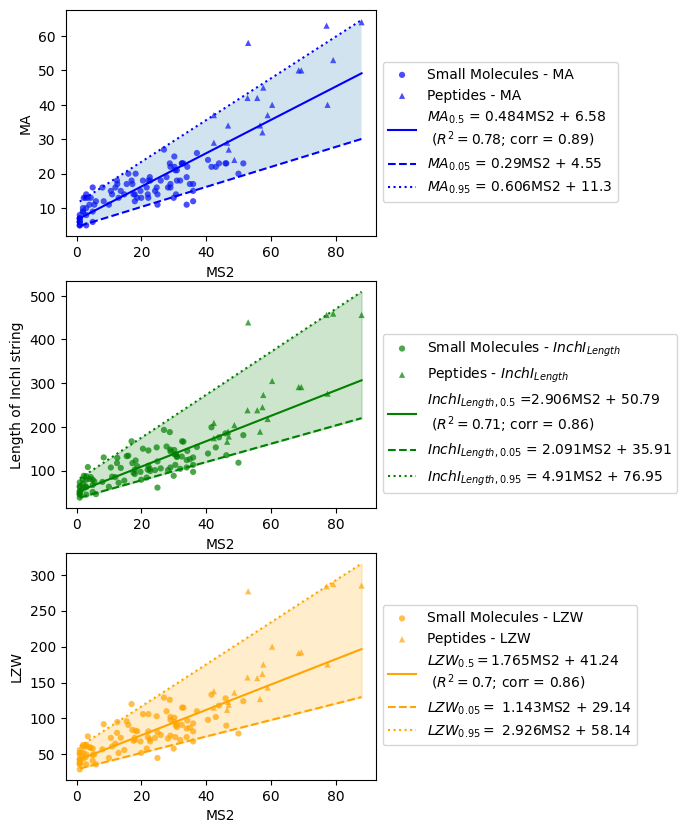

In [74]:
quantile = 0.05

xv_AI = df_data_2["MA"].to_numpy().astype('int')
xv_LZW = np.array([len(x) for x in df_data_2["InChI"].to_numpy()])
yv_MA= df_data_2["MS2"].to_numpy()

fig, axes = plt.subplots(3, 1, figsize=(4, 10))

ax,ax2,ax3 = axes

ax.scatter(yv_MA[filttp],xv_AI[filttp] , c="blue", s=szm, marker = "o", label="Small Molecules - MA",
           alpha=0.7, edgecolors='none')

ax.scatter(yv_MA[~filttp],xv_AI[~filttp] , c="blue", s=szm, marker = "^", label="Peptides - MA",
           alpha=0.7, edgecolors='none')

qr1 = QuantileRegressor(quantile=0.5, alpha=0, solver="highs")
qr2 = QuantileRegressor(quantile=0.5, alpha=0, solver="highs")
reg1 = qr1.fit(yv_MA.reshape(-1, 1),xv_AI)
reg2 = qr2.fit(yv_MA.reshape(-1, 1),xv_LZW)

qr1l = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
qr1u = QuantileRegressor(quantile=1-quantile, alpha=0, solver="highs")
qreg1l = qr1l.fit(yv_MA.reshape(-1, 1),xv_AI)
qreg1u = qr1u.fit(yv_MA.reshape(-1, 1),xv_AI)

x_fit1 = np.linspace(yv_MA.min(), yv_MA.max(), 100)
y_fit1 = reg1.predict(x_fit1.reshape(-1, 1))

ax.plot(x_fit1, y_fit1, c="blue", label= "$MA_{0.5}$ = "+str(round(reg1.coef_[0],3))+"MS2 + "+str(round(reg1.intercept_,2))+'\n ($R^2 = $'+str(np.round(reg1.score(yv_MA.reshape(-1, 1),xv_AI.reshape(-1, 1)),2))+'; corr = '+str(round(np.corrcoef(np.array([yv_MA,xv_AI]))[0][1],2))+")")

y_fit1l = qreg1l.predict(x_fit1.reshape(-1, 1))
ax.plot(x_fit1, y_fit1l, c="blue",ls="--", label= "$MA_{0.05}$ = "+str(round(qreg1l.coef_[0],3))+"MS2 + "+str(round(qreg1l.intercept_,2)))

y_fit1u = qreg1u.predict(x_fit1.reshape(-1, 1))
ax.plot(x_fit1, y_fit1u, c="blue",ls=":", label= "$MA_{0.95}$ = "+str(round(qreg1u.coef_[0],3))+"MS2 + "+str(round(qreg1u.intercept_,2)))

ax.fill_between(x_fit1,y_fit1l, y_fit1u,alpha=0.2)

ax.set_ylabel("MA")
ax.set_xlabel("MS2")

qr2l = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
qr2u = QuantileRegressor(quantile=1-quantile, alpha=0, solver="highs")
qreg2l = qr2l.fit(yv_MA.reshape(-1, 1),xv_LZW)
qreg2u = qr2u.fit(yv_MA.reshape(-1, 1),xv_LZW)


x_fit2 = np.linspace(yv_MA.min(), yv_MA.max(), 100)
y_fit2 = reg2.predict(x_fit2.reshape(-1, 1))

ax2.scatter(yv_MA[filttp],xv_LZW[filttp] , c="green", s=szm, marker = "o", label="Small Molecules - $InchI_{Length}$",
           alpha=0.7, edgecolors='none')

ax2.scatter(yv_MA[~filttp],xv_LZW[~filttp] , c="green", s=szm, marker = "^", label="Peptides - $InchI_{Length}$",
           alpha=0.7, edgecolors='none')

ax2.plot(x_fit2, y_fit2, c="green", label= "$InchI_{Length,0.5}$ ="+str(round(reg2.coef_[0],3))+"MS2 + "+str(round(reg2.intercept_,2))+'\n ($R^2 = $'+str(np.round(reg2.score(yv_MA.reshape(-1, 1),xv_LZW.reshape(-1, 1)),2))+'; corr = '+str(round(np.corrcoef(np.array([yv_MA,xv_LZW]))[0][1],2))+")")

y_fit2l = qreg2l.predict(x_fit2.reshape(-1, 1))
ax2.plot(x_fit2, y_fit2l, c="green",ls="--", label= "$InchI_{Length,0.05}$ = "+str(round(qr2l.coef_[0],3))+"MS2 + "+str(round(qr2l.intercept_,2)))

y_fit2u = qreg2u.predict(x_fit2.reshape(-1, 1))
ax2.plot(x_fit2, y_fit2u, c="green",ls=":", label= "$InchI_{Length,0.95}$ = "+str(round(qr2u.coef_[0],3))+"MS2 + "+str(round(qr2u.intercept_,2)))

ax2.fill_between(x_fit2,y_fit2l, y_fit2u,alpha=0.2,color="green")

ax2.set_ylabel("Length of InchI string")
ax2.set_xlabel("MS2")

xv_LZW = df_lzwai3["LZW-sz"].to_numpy()

qr2 = QuantileRegressor(quantile=0.5, alpha=0, solver="highs")
reg2 = qr2.fit(yv_MA.reshape(-1, 1),xv_LZW)


qr2li = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
qr2ui = QuantileRegressor(quantile=1-quantile, alpha=0, solver="highs")
qreg2li = qr2li.fit(yv_MA.reshape(-1, 1),xv_LZW)
qreg2ui = qr2ui.fit(yv_MA.reshape(-1, 1),xv_LZW)


x_fit2i = np.linspace(yv_MA.min(), yv_MA.max(), 100)
y_fit2i = reg2.predict(x_fit2i.reshape(-1, 1))

ax3.scatter(yv_MA[filttp],xv_LZW[filttp] , c="orange", s=szm, marker = "o", label="Small Molecules - LZW",
           alpha=0.7, edgecolors='none')

ax3.scatter(yv_MA[~filttp],xv_LZW[~filttp] , c="orange", s=szm, marker = "^", label="Peptides - LZW",
           alpha=0.7, edgecolors='none')

ax3.plot(x_fit2i, y_fit2i, c="orange", label= "$LZW_{0.5} =$"+str(round(reg2.coef_[0],3))+"MS2 + "+str(round(reg2.intercept_,2))+'\n ($R^2 = $'+str(np.round(reg2.score(yv_MA.reshape(-1, 1),xv_LZW.reshape(-1, 1)),2))+'; corr = '+str(round(np.corrcoef(np.array([yv_MA,xv_LZW]))[0][1],2))+")")


y_fit2li = qreg2li.predict(x_fit2i.reshape(-1, 1))
ax3.plot(x_fit2i, y_fit2li, c="orange",ls="--", label= "$LZW_{0.05} =$ "+str(round(qr2li.coef_[0],3))+"MS2 + "+str(round(qr2li.intercept_,2)))

y_fit2ui = qreg2ui.predict(x_fit2i.reshape(-1, 1))
ax3.plot(x_fit2i, y_fit2ui, c="orange",ls=":", label= "$LZW_{0.95} =$ "+str(round(qr2ui.coef_[0],3))+"MS2 + "+str(round(qr2ui.intercept_,2)))

ax3.fill_between(x_fit2i,y_fit2li, y_fit2ui,alpha=0.2,color="orange")


ax3.set_ylabel("LZW")
ax3.set_xlabel("MS2")
ax.legend(bbox_to_anchor=(1, 0.8))
ax2.legend(bbox_to_anchor=(1, 0.8))
ax3.legend(bbox_to_anchor=(1, 0.8))

plt.show()

In [69]:
plt.rcdefaults()

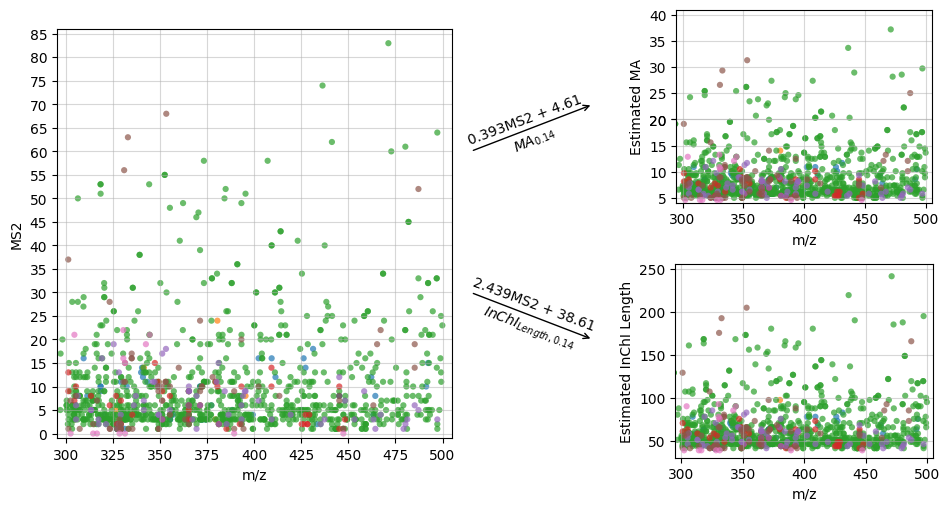

In [70]:
# It is also possible to show that the threshold of Marshall et al. (2021) is arbitrary and could be defined in terms of the Length of Inchi codes.
cmapv=plt.cm.tab10
szm = 20
fig = plt.figure(constrained_layout=True, figsize = (10,5))
gs = GridSpec(2, 2, figure=fig)
ax = fig.add_subplot(gs[:, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, 1]) 

yv_MA = df_N["Number.of.peaks"].to_numpy().astype('int')
xv_AI = df_N["m.z"].to_numpy().astype('float')
catego = sorted(list(set(df_N["Source"].to_numpy())))

xv_AI_ori = df_data_2["MA"].to_numpy().astype('int')
yv_MA_ori= df_data_2["MS2"].to_numpy()

qr = QuantileRegressor(quantile=0.14, alpha=0, solver="highs")
qreg = qr.fit(yv_MA_ori.reshape(-1, 1),xv_AI_ori)

for n,vvc in enumerate(catego):
    filt_i = (df_N["Source"].to_numpy() == vvc)

    ax.scatter(xv_AI[filt_i],yv_MA[filt_i], c=[cmapv(n)], s=szm, marker = "o", label=vvc,
           alpha=0.7, edgecolors='none')

ax.scatter(df_Mun["MS2 Parent"].to_numpy(),df_Mun["Total Peaks"].to_numpy(), c=[cmapv(len(catego))], s=szm, marker = "o", label="Murchison extract",
           alpha=0.7, edgecolors='none')    

ax.set_xlabel("m/z")
ax.set_ylabel("MS2")
ax.set_yticks([5*i for i in range(18)])

ax.set_xlim([295,505])
ax.set_ylim([-1,86])

ax.grid(True, alpha = 0.5)

for n,vvc in enumerate(catego):
    filt_i = (df_N["Source"].to_numpy() == vvc)

    ax2.scatter(xv_AI[filt_i],qreg.predict(yv_MA[filt_i].reshape(-1, 1)), c=[cmapv(n)], s=szm, marker = "o", label=vvc,
           alpha=0.7, edgecolors='none')

ax2.scatter(df_Mun["MS2 Parent"].to_numpy(),qreg.predict(df_Mun["Total Peaks"].to_numpy().reshape(-1, 1)), c=[cmapv(len(catego))], s=szm, marker = "o", label="Murchison extract",
           alpha=0.7, edgecolors='none')    

ax2.set_xlabel("m/z")
ax2.set_ylabel("Estimated MA")
ax2.set_yticks([5,10,15,20,25,20,30,35,40])

ax2.set_xlim([295,505])
ax2.set_ylim([4,41])

ax2.grid(True, alpha = 0.5)

xv_AI_In = np.array([len(x) for x in df_data_2["InChI"].to_numpy()])
yv_MA_In= df_data_2["MS2"].to_numpy()

qrI = QuantileRegressor(quantile=0.14, alpha=0, solver="highs")
qregI = qrI.fit(yv_MA_In.reshape(-1, 1),xv_AI_In)

for n,vvc in enumerate(catego):
    filt_i = (df_N["Source"].to_numpy() == vvc)

    ax3.scatter(xv_AI[filt_i],qregI.predict(yv_MA[filt_i].reshape(-1, 1)), c=[cmapv(n)], s=szm, marker = "o", label=vvc,
           alpha=0.7, edgecolors='none')

ax3.scatter(df_Mun["MS2 Parent"].to_numpy(),qregI.predict(df_Mun["Total Peaks"].to_numpy().reshape(-1, 1)), c=[cmapv(len(catego))], s=szm, marker = "o", label="Murchison extract",
           alpha=0.7, edgecolors='none')    

ax3.set_xlabel("m/z")
ax3.set_ylabel("Estimated InChI Length")

ax3.set_xlim([295,505])
ax3.set_ylim([30,255])

ax3.grid(True, alpha = 0.5)



ax.set_aspect(2.5)
ax2.set_aspect(4.3)
ax3.set_aspect(0.7)
    
ax.annotate("", xy=(580, 20), xytext=(515, 30),
            arrowprops=dict(arrowstyle="->"),annotation_clip=False)

ax.annotate("", xy=(580, 70), xytext=(515, 60),
            arrowprops=dict(arrowstyle="->"),annotation_clip=False)

ax.text(520, 24, "$InChI_{Length,0.14}$", ha='left', va='bottom',
         transform_rotates_text=True, rotation=-8.5, rotation_mode='anchor')

ax.text(540, 59, "$MA_{0.14}$", ha='left', va='bottom',
         transform_rotates_text=True, rotation=+10, rotation_mode='anchor')

ax.text(515, 31, str(round(qregI.coef_[0],3))+"MS2 + "+str(round(qregI.intercept_,2)), ha='left', va='bottom',
         transform_rotates_text=True, rotation=-8.5, rotation_mode='anchor')

ax.text(515, 61, str(round(qreg.coef_[0],3))+"MS2 + "+str(round(qreg.intercept_,2)), ha='left', va='bottom',
         transform_rotates_text=True, rotation=+8.5, rotation_mode='anchor')

plt.show()